In [1]:
from NID.datasets import Pinky40
from NID.models import DnCNN
from NID.utils import weights_init_kaiming, batch_PSNR

import numpy as np
import scipy.io as sio 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass

import os
import h5py
import random
import cv2
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

@dataclass
class training_configurations: 
    '''class for storing options of the netowrk training'''
    preprocess: bool = False  
    batchSize: int = 256    # training batch size 
    num_of_layers: int = 17 # number of total layers 
    epochs: int = 3   #number of training epochs 
    milestone: int = 1 # when to decay learning rate 
    lr: float = 1e-3  # initial learning rate 
    outf: str = 'logs' #path of log files 
    mode: str = 'S' #with known noise level (S) or blind training (B)
    noiseL: float = 0.1 # noise level
    val_noiseL: float = 0.2 # nosie level used on validation set 

# prepare data

In [8]:
dataset_train.patch

29

In [6]:
frames

3036

In [2]:
dataset_train = Pinky40(train=True, patch=29)
print(type(dataset_train))
dataset_val = Pinky40(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=4, 
                         batch_size=256, shuffle=True)
print("# of training samples: %d\n" % len(dataset_train))
print("# of testing samples: %d\n" % len(dataset_val))

<class 'NID.datasets.Pinky40'>
# of training samples: 194581

# of testing samples: 311



# configure training options

In [ ]:
opt = training_configurations()
opt

# build model 

In [ ]:
net = DnCNN(channels=1, num_of_layers=opt.num_of_layers)
# Move to GPU
device_ids = [0]
#initialize weights
file_results = os.path.join(opt.outf, 'net_{}_state0.pth'.format(opt.num_of_layers))

if os.path.exists(file_results):
    print('use the trained model as the initialization')
    model = nn.DataParallel(net, device_ids=device_ids).cuda()
    model.load_state_dict(torch.load(file_results))
    model.eval()
else:
    print("start from scratch to initialize the model")
    net.apply(weights_init_kaiming)
    if len(device_ids)==1: 
        device = torch.device('cuda:0')
        model = net.to(device)
    else: 
        model = nn.DataParallel(net, device_ids=device_ids).cuda()
    
criterion = nn.MSELoss(reduction='sum')
criterion.cuda()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=opt.lr)
# training
writer = SummaryWriter(opt.outf)
step = 0
# opt.lr = 1e-4

# start training - GPU

In [ ]:
output_file = os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers))
train_again = True 

if os.path.exists(output_file) and (not train_again): 
    # load the saved model directly 
    model.load_state_dict(torch.load(output_file))
else: 
    # train the model again 
    for epoch in range(opt.epochs):
        # reduce the learning rate after opt.milestone iterations
        if epoch < opt.milestone:
            current_lr = opt.lr
        else:
            current_lr = opt.lr / 10.

        # set learning rate
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        print('epoch %d: learning rate %f' % (epoch, current_lr))
        
        # train
        for i, data in enumerate(loader_train, 0):
            # training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            img_train = data
            
            # generate noisy images 
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=opt.noiseL)
            if opt.mode == 'B':
                noise = torch.zeros(img_train.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            imgn_train = img_train + noise
            img_train, imgn_train = Variable(img_train.cuda()), Variable(imgn_train.cuda())
            noise = Variable(noise.cuda())
            
            # define the model output
            out_train = model(imgn_train)
            
            # define the objective function 
            loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
            
            # update model parameters using back-propagation 
            loss.backward()
            optimizer.step()
            
            # results
            model.eval()
            out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
            psnr_train = batch_PSNR(out_train, img_train, 1.)
            print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
                (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
            # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
            
            if step % 100 == 0:
                # Log the scalar values
                writer.add_scalar('loss', loss.item(), step)
                writer.add_scalar('PSNR on training data', psnr_train, step)
            step += 1
            
        # evaluate the model using the test data 
        model.eval()

        psnr_val = 0
        for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
        psnr_val /= len(dataset_val)
        print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
        writer.add_scalar('PSNR on validation data', psnr_val, epoch)

        # save model
        torch.save(model.state_dict(), os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers)))


# test it on real data

In [24]:
data_path = os.path.join(dataset_train.root, 'testdata')
real_data = sio.loadmat(os.path.join(data_path, 'real_2pdata.mat'))
A2p = real_data['A']
A2p_corr = real_data['A_corr']
A2p_raw = real_data['A_raw']

In [25]:
def plot_2p_results(neuron_id, cmap='jet'): 
#     img_raw = A_corr[:, :, neuron_id]
    img_raw = A2p_raw[:,:,neuron_id]

    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * opt.noiseL
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A2p[:, :, neuron_id].squeeze()
    img_ai_raw = A2p_raw[:,:,neuron_id].squeeze()
    img_diff= img_ai_raw.squeeze() - img_ai
    
    img_diff = img_diff / noise * 0.1
    print(img_diff.shape)
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1, img_diff]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$', 'difference']
#     fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1], [-0.2, 0.2]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,5, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.title(title)
#         plt.colorbar(im, cax=cax)
    
#     plt.tight_layout()
    
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
#     plt.figure(figsize=(5, 8))
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.1,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()

    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.5, 2], [-0.5,2], c='r')
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
#     plt.tight_layout()
    
    return img_raw, img_denoised

In [26]:
dummy_input = torch.randn(1, 1, 60, 80, device='cuda')
file_onnx = os.path.join(opt.outf, 'net_{}.onnx'.format(opt.num_of_layers))
torch.onnx.export(model, dummy_input, file_onnx)

(60, 80)


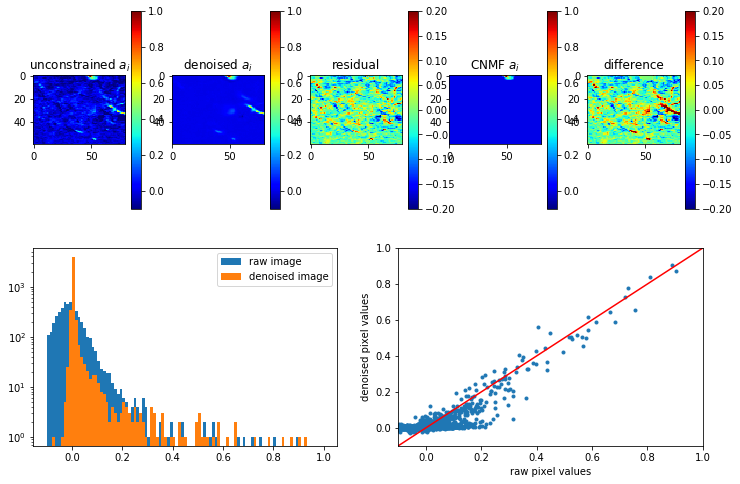

In [27]:
example_id = 20
img_raw, img_denoised = plot_2p_results(20)

Text(0.5, 1.0, 'NN-denoiser')

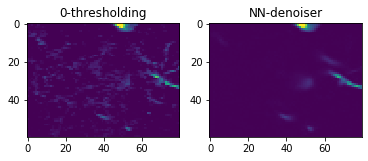

In [28]:
plt.subplot(121)
plt.imshow((img_raw * (img_raw>0)).squeeze(), clim=[0,1])
plt.title('0-thresholding')
plt.subplot(122)
plt.imshow(img_denoised.squeeze(), clim=[0,1])
plt.title('NN-denoiser')

# test baylor data 

In [34]:
real_data = sio.loadmat(os.path.join(data_path, 'baylor_data.mat'))
A = real_data['A']
A_corr = real_data['A_corr']
A_em = real_data['A_em']

In [35]:
def plot_baylor_results(neuron_id, plane_id, cmap='jet'): 
    img_raw = A_corr[:, :, plane_id, neuron_id].reshape(1,1, 58, 129)
    noise = img_raw[img_raw!=0].std()
    img_raw = img_raw / img_raw.max() 
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A[:, :, plane_id, neuron_id].squeeze()
    img_pi = A_em[:,:,plane_id, neuron_id].squeeze()
    
    imgs = [img_pi/img_pi.max(), img_ai/img_ai.max(), img_raw.squeeze(), img_denoised.squeeze(), img_output.squeeze()]
    titles = ['EM footprint', '2P footprint', 'corr. image', 'denoised corr. image', 'residual']
    fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    for img, title, ax in zip(imgs, titles, axs): 
        im = ax.imshow(img, cmap=cmap, clim=[-0.1, 0.5])
        ax.set_ylabel(title)
    

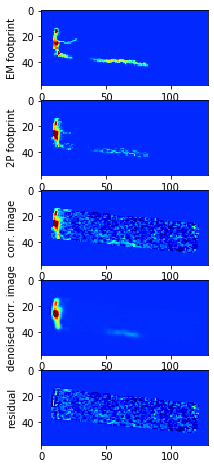

In [36]:
plot_baylor_results(5,2)

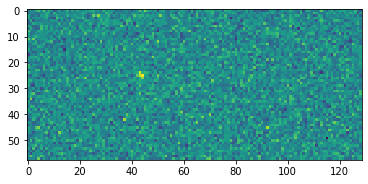

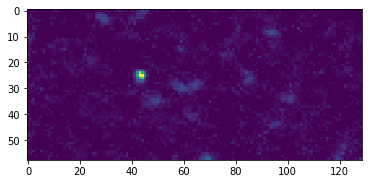

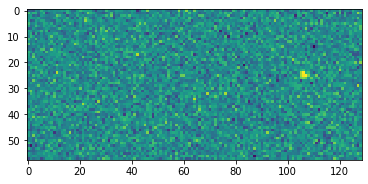

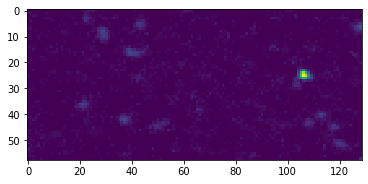

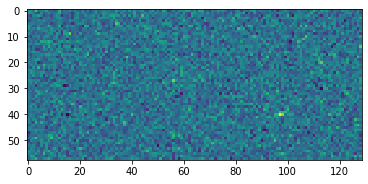

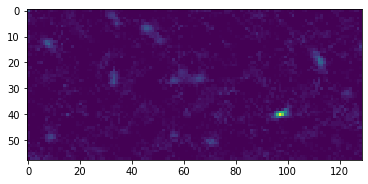

In [ ]:
#Here we visualize how well the model actually performs on the test data that we defined for it
for k in range(len(dataset_train)):
    img_val = torch.unsqueeze(dataset_val[k], 0)
    noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
    imgn_val = img_val + noise
    img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
    out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
    imgn_valCPU = imgn_val.detach().cpu().numpy()
    imgn_valCPU = imgn_valCPU.squeeze()
    out_valCPU = out_val.detach().cpu().numpy()
    out_valCPU = out_valCPU.squeeze()
    
    plt.figure()
    plt.imshow(imgn_valCPU)
    plt.figure()
    plt.imshow(out_valCPU)
    plt.show()
    input()
#     psnr_val += batch_PSNR(out_val, img_val, 1.)
# psnr_val /= len(dataset_val)